In [1]:
import os
import nibabel as nib
import numpy as np
import skimage
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import cv2, pickle

In [ ]:
# Prototype with one subject segmentation first
print(os.getcwd())
image_path = r'/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/imagesTr'
tumor_path = r'/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr'

# Organ segmentation files obtained from TotalSegmentator v1.5.7
# Results are generated from the run_total_segmentator.py script
label_organs_path = r'/home/azureuser/cloudfiles/code/Users/data/msd_segmentation/Task06_Lung/labelsTr'
# Labels for lung:
# 13	lung_upper_lobe_left	superior lobe of left lung
# 14	lung_lower_lobe_left	inferior lobe of left lung
# 15	lung_upper_lobe_right	superior lobe of right lung
# 16	lung_middle_lobe_right	middle lobe of right lung
# 17	lung_lower_lobe_right	inferior lobe of right lung

# List all the files in the image path and label path, exclude files that start with ._ 
image_list = [f for f in os.listdir(image_path) if not f.startswith('._') and  'nii.gz' in f]
tumor_label_value = 1
number_of_organs = 104 

# Sort the list
image_list.sort()
print(len(image_list))

In [3]:
image_id_dict ={}
for image_name in image_list:
    label_organ_file = os.path.join(label_organs_path, image_name)
    label_organ = sitk.ReadImage(label_organ_file)
    img_emb_list = []

    # Get 3D matrix from the image
    label_organ_data = sitk.GetArrayFromImage(label_organ)

    for i in range(label_organ_data.shape[0]):
        label_slice = label_organ_data[i,:,:]
        # For label slice, create a dictionary where key is the pixel value and value is the number of pixels different from 0
        label_dict = dict(zip(*np.unique(label_slice, return_counts=True)))
        label_vector = np.zeros(104, dtype=int)
        for key, value in label_dict.items():
            if key > 0:
                label_vector[key-1] = value

        img_emb_list.append(label_vector)

    # concatenate the vectors into a matrix
    full_emb = np.stack(img_emb_list, axis=0)
    image_id_dict[image_name] = full_emb.copy()
    
output_file = '/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_2D_per_organ.pkl'
with open(output_file, "wb") as f:
    pickle.dump(image_id_dict, f)
print("Saved file: ", output_file)

Saved file:  /home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_2D_per_organ.pkl


In [4]:
output_file = '/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_2D_per_organ.pkl'
# Load pickle file
with open(output_file, "rb") as f:
    data_dict = pickle.load(f)
data_dict.keys()

dict_keys(['lung_001.nii.gz', 'lung_003.nii.gz', 'lung_004.nii.gz', 'lung_005.nii.gz', 'lung_006.nii.gz', 'lung_009.nii.gz', 'lung_010.nii.gz', 'lung_014.nii.gz', 'lung_015.nii.gz', 'lung_016.nii.gz', 'lung_018.nii.gz', 'lung_020.nii.gz', 'lung_022.nii.gz', 'lung_023.nii.gz', 'lung_025.nii.gz', 'lung_026.nii.gz', 'lung_027.nii.gz', 'lung_028.nii.gz', 'lung_029.nii.gz', 'lung_031.nii.gz', 'lung_033.nii.gz', 'lung_034.nii.gz', 'lung_036.nii.gz', 'lung_037.nii.gz', 'lung_038.nii.gz', 'lung_041.nii.gz', 'lung_042.nii.gz', 'lung_043.nii.gz', 'lung_044.nii.gz', 'lung_045.nii.gz', 'lung_046.nii.gz', 'lung_047.nii.gz', 'lung_048.nii.gz', 'lung_049.nii.gz', 'lung_051.nii.gz', 'lung_053.nii.gz', 'lung_054.nii.gz', 'lung_055.nii.gz', 'lung_057.nii.gz', 'lung_058.nii.gz', 'lung_059.nii.gz', 'lung_061.nii.gz', 'lung_062.nii.gz', 'lung_064.nii.gz', 'lung_065.nii.gz', 'lung_066.nii.gz', 'lung_069.nii.gz', 'lung_070.nii.gz', 'lung_071.nii.gz', 'lung_073.nii.gz', 'lung_074.nii.gz', 'lung_075.nii.gz', '

In [5]:
import tqdm

# Create a dataframe to store the metrics per file and 2D image
df2d = pd.DataFrame(columns=['filename', 'slice', 'cancer_stage', 'tumor_area'])
df3d = pd.DataFrame(columns=['filename','cancer_stage'])

# #iterate through the list of files image_list and label_list
# for image_name, label_name in tqdm.tqdm(zip(image_list, label_list)):
(stats_list_2d, stats_list_3d) = ([], [])
for image_name in image_list: 
#for image_name in tqdm.tqdm(image_list):

    (image_file, tumor_file, organs_file) = (os.path.join(image_path, image_name), os.path.join(tumor_path, image_name), os.path.join(label_organs_path, image_name))
    (image, tumor, lung) = (sitk.ReadImage(image_file), sitk.ReadImage(tumor_file), sitk.ReadImage(organs_file))
    (image_data, tumor_data, organs_data) = (sitk.GetArrayFromImage(image), sitk.GetArrayFromImage(tumor), sitk.GetArrayFromImage(lung))
    spacing = image.GetSpacing()

    # For tumo image make zero voxels except for tumor label
    tumor_data[tumor_data != tumor_label_value] = 0
    tumor_data[tumor_data == tumor_label_value] = 1

    tumor = sitk.GetImageFromArray(tumor_data)
    cc = sitk.ConnectedComponent(tumor)
    stats = sitk.LabelIntensityStatisticsImageFilter()
    stats.Execute(cc, tumor)
    print(tumor_file, stats.GetNumberOfLabels())
    # Get array of connected component numbers
    cc_tumor_array = sitk.GetArrayFromImage(cc)

    # Creates dictionary where key is tuple consisting of subject ID and label number
    #tumor_size_list = []
    for l in stats.GetLabels():
        # Ignore if number of voxels is less than 6

        # Remove spurius or flat objects objects 
        if stats.GetNumberOfPixels(l) < 3 or stats.GetBoundingBox(l)[-1] == 1:
            cc_tumor_array[cc_tumor_array == l] = 0
            continue

        # Count number of voxels in this connected component
        voxel_count = np.sum(cc_tumor_array == l)
        #Initialize dictionary containing different metrics
        cc_dictionary = {}
        cc_dictionary['image_name'] = image_name
        cc_dictionary['PhysicalSize_cm3'] = stats.GetPhysicalSize(l) * spacing[0] * spacing[1] * spacing[2] / 1000
        cc_dictionary['NumberOfVoxels'] = stats.GetNumberOfPixels(l)
        cc_dictionary['Roundness'] = stats.GetRoundness(l)
        cc_dictionary['Elongation'] = stats.GetElongation(l)
        cc_dictionary['Flatness'] = stats.GetFlatness(l)
        cc_dictionary['EquivalentSphericalRadius_cm'] = stats.GetEquivalentSphericalRadius(l)/10
        cc_dictionary['EquivalentSphericalPerimeter_cm'] = stats.GetEquivalentSphericalPerimeter(l)/10
        cc_dictionary['EquivalentEllipsoidDiameter'] = stats.GetEquivalentEllipsoidDiameter(l)
        cc_dictionary['major_axis_length_cm'] = max(stats.GetEquivalentEllipsoidDiameter(l)) / 10
        cc_dictionary['centroid'] = stats.GetCentroid(l)
        cc_dictionary['bounding_box'] = stats.GetBoundingBox(l)
        cc_dictionary['spacing']= spacing

        # Get the number of voxels in the tumor that are in the organ
        tumor_bbox = stats.GetBoundingBox(l)
        # Get voxels only in the tumor bounding box
        (x0,y0,z0,x1,y1,z1)= tumor_bbox
        # Add the width, height and depth to the x0, y0, z0
        (x1,y1,z1) = (x1+x0, y1+y0, z1+z0)
        # Coordinate systems ITK - Numpy are different:
        (organ_bbox_array, tumor_bbox_array)  = (organs_data[z0:z1, y0:y1, x0:x1], cc_tumor_array[z0:z1, y0:y1, x0:x1])

        # Quantifies tumor in each organ
        for i in range(number_of_organs+1):
            cc_dictionary['organ_'+str(i)+'_voxel_count'] = 0
            # organ_voxel_count = np.sum(np.logical_and(cc_tumor_array == l, organs_data == i))

        (voxel_values, voxel_counts) = np.unique(organ_bbox_array[tumor_bbox_array == l], return_counts=True)
        for (v,c) in zip(voxel_values, voxel_counts):
            cc_dictionary['organ_'+str(v)+'_voxel_count'] = c
        stats_list_3d.append(cc_dictionary.copy())

    # 2D Report -- Iterate through the slices
    for i in range(organs_data.shape[0]):
        tumor_slice = cc_tumor_array[i,:,:]
        organs_slice = organs_data[i,:,:]

        if not np.any(tumor_slice):
            continue

        number_of_tumors = 0
        # OpenCV returns number of objects + 1
        number_of_tumors = cv2.connectedComponents(tumor_slice.astype('uint8'),connectivity=8)[0] - 1

        # Calculate area of the tumors
        tumor_area_cm2 = np.sum(tumor_slice == 1) * spacing[0] * spacing[1] / 100

        # Localize where in the organs the tumor is
        organ_voxel_count_2d_dict = {}
        organ_voxel_count_2d_dict['filename']= image_name
        organ_voxel_count_2d_dict['slice']= i
        organ_voxel_count_2d_dict['number_of_tumors']= number_of_tumors
        organ_voxel_count_2d_dict['tumor_area_cm2']= tumor_area_cm2
        organ_voxel_count_2d_dict['spacing'] = spacing
        for i in range(number_of_organs+1):
            organ_voxel_count = np.sum(np.logical_and(tumor_slice > 0, organs_slice == i))
            organ_voxel_count_2d_dict['organ_'+str(i)+'_voxel_count'] = organ_voxel_count

        stats_list_2d.append(organ_voxel_count_2d_dict.copy())

df_tumor_report_2d = pd.DataFrame(stats_list_2d)
df_tumor_report_3d = pd.DataFrame(stats_list_3d)

df_tumor_report_3d.to_csv('/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_3D_tumor_per_organ.csv', index=False)
df_tumor_report_2d.to_csv('/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_2D_tumor_per_organ.csv', index=False)


/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_001.nii.gz 9
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_003.nii.gz 1
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_004.nii.gz 1
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_005.nii.gz 1
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_006.nii.gz 2
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_009.nii.gz 10
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_010.nii.gz 2
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_014.nii.gz 1
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_015.nii.gz 1
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_016.nii.gz 1
/home/azureuser/cloudfiles/code/Users/data/msd/Task06_Lung/labelsTr/lung_018.nii.gz 1
/home/azureuser/cloudfiles/code/Users/data/msd/Task06

In [6]:
# Read the data frames
df3d = pd.read_csv('/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_3D_tumor_per_organ.csv')
df2d = pd.read_csv('/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_2D_tumor_per_organ.csv')


In [7]:
df3d.columns

Index(['image_name', 'PhysicalSize_cm3', 'NumberOfVoxels', 'Roundness',
       'Elongation', 'Flatness', 'EquivalentSphericalRadius_cm',
       'EquivalentSphericalPerimeter_cm', 'EquivalentEllipsoidDiameter',
       'major_axis_length_cm',
       ...
       'organ_95_voxel_count', 'organ_96_voxel_count', 'organ_97_voxel_count',
       'organ_98_voxel_count', 'organ_99_voxel_count', 'organ_100_voxel_count',
       'organ_101_voxel_count', 'organ_102_voxel_count',
       'organ_103_voxel_count', 'organ_104_voxel_count'],
      dtype='object', length=118)

In [8]:
# # Iterate through the slices
# for index, row in df3d.iterrows():
#     # Get index of colums starting with organ
#     organ_columns = df3d.columns[df3d.columns.str.startswith('organ')]
#     NumberOfVoxels = row.NumberOfVoxels

#     # Normalize the number of voxels in each organ by the total number of voxels
#     for organ in organ_columns:
#         df3d.loc[index, organ] = df3d.loc[index, organ] / NumberOfVoxels

image_name_list_with_tumor = df3d.image_name.unique().tolist()
image_name_list_all_subjects = [f for f in data_dict.keys()]
image_name_list_without_tumor = list(set(image_name_list_all_subjects) - set(image_name_list_with_tumor))

subject_list = []
# Group by image name and iterate through the groups
for name, group in df3d.groupby('image_name'):
    subject_dict = {}
    # Number of tumors
    number_tumors_group = len(group)    

    max_tumor_size_group = max(group.major_axis_length_cm)
    # Cancer stage https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging
    # Value stage 1: 1 tumor less than 3cm
    # Value stage 2: 1 tumor between 3cm and  5cm
    # Value stage 3: between 5cm to 7cm or more than 1 tumor of the lobe of the lung
    # Value stage 4: larger than 7cm or more than 1 tumor of the lung
    cancer_stage = -1 # No Cancer
    if max_tumor_size_group < 3 and  number_tumors_group == 1:
        cancer_stage = 1
    elif (max_tumor_size_group > 3 and max_tumor_size_group < 5) and number_tumors_group == 1:
            cancer_stage = 2
    elif max_tumor_size_group > 5 and max_tumor_size_group < 7 or number_tumors_group >= 1:
            cancer_stage = 3
    elif max_tumor_size_group > 7 or number_tumors_group >= 1 :
        cancer_stage = 4

    subject_dict['name'] = name
    subject_dict['max_tumor_size'] = max_tumor_size_group
    subject_dict['number_tumors'] = number_tumors_group
    subject_dict['cancer_stage'] = cancer_stage
    
    subject_list.append(subject_dict.copy())

for name in image_name_list_without_tumor:
    subject_dict = {}
    subject_dict['name'] = name
    subject_dict['max_tumor_size'] = 0
    subject_dict['number_tumors'] = 0
    subject_dict['cancer_stage'] = -1
    subject_list.append(subject_dict.copy())

df_subject = pd.DataFrame(subject_list)
df_subject.to_csv('/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_3D_subject.csv', index=False)

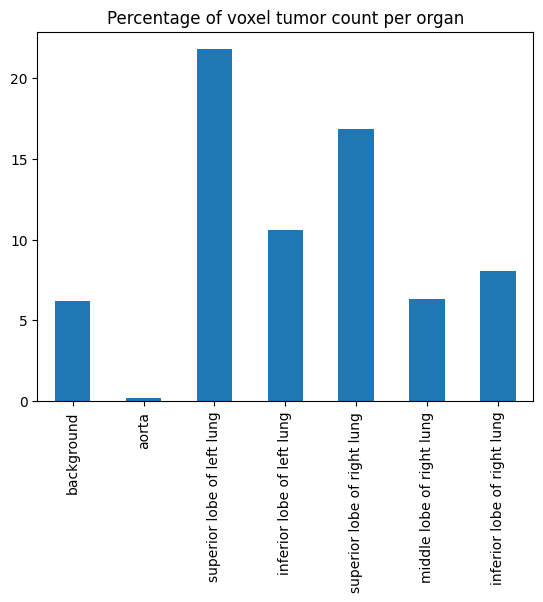

In [9]:
# Distribution of tumor vs organ number where values are non-zero
df3d_organ = df3d.loc[:, df3d.columns.str.startswith('organ')]
# Remove columns with all zeros
df3d_organ = df3d_organ.loc[:, (df3d_organ != 0).any(axis=0)]

# # Remove columns with less than 100 voxel counts
df3d_organ = df3d_organ.loc[:, df3d_organ.sum() > 400]

# Rename columns as follows: 
# organ 0 is backbround
# organ 7 is aorta
# organ 13	lung_upper_lobe_left	superior lobe of left lung
# organ 14	lung_lower_lobe_left	inferior lobe of left lung
# organ 15	lung_upper_lobe_right	superior lobe of right lung
# organ 16	lung_middle_lobe_right	middle lobe of right lung
# organ 17	lung_lower_lobe_right	inferior lobe of right lung

df3d_organ.columns = ['background', 'aorta', 'superior lobe of left lung', 'inferior lobe of left lung', 'superior lobe of right lung', 'middle lobe of right lung', 'inferior lobe of right lung']

# Normalize the number of voxels as cm3
df3d_organ = df3d_organ.div(df3d_organ.sum(axis=1), axis=0)

# Plot histogram of number of voxels per organ
df3d_organ.sum().plot(kind='bar', title='Percentage of voxel tumor count per organ')


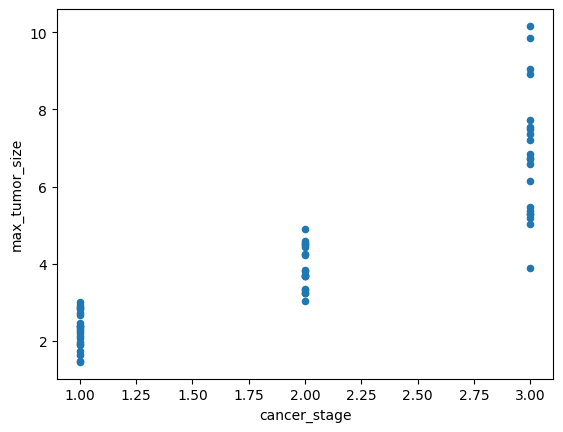

In [10]:
# Plot distribution of cancer stage for integer values vs tumor size
df_subject.plot.scatter(x='cancer_stage', y='max_tumor_size')

In [11]:
# Iterate through the slices
for index, row in df3d.iterrows():
    # Get index of colums starting with organ
    organ_columns = df3d.columns[df3d.columns.str.startswith('organ')]
    # Normalize the number of voxels in each organ by the total number of voxels
    for organ in organ_columns:
        df3d.loc[index, organ] = df3d.loc[index, organ] / row.NumberOfVoxels


subject_list = []
# Group by image name and iterate through the groups
for name, group in df3d.groupby('image_name'):
    subject_dict = {}
    # Number of tumors
    number_tumors_group = len(group)    

    max_tumor_size_group = max(group.major_axis_length_cm)
    # Cancer stage https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging
    # Value stage 1: 1 tumor less than 3cm
    # Value stage 2: 1 tumor between 3cm and  5cm
    # Value stage 3: between 5cm to 7cm or more than 1 tumor of the lobe of the lung
    # Value stage 4: larger than 7cm or more than 1 tumor of the lung
    cancer_stage = -1 # No Cancer
    if number_tumors_group == 1:
        if max_tumor_size_group < 3:
            cancer_stage = 1
        elif max_tumor_size_group > 3 or max_tumor_size_group < 5:
            cancer_stage = 2
    elif max_tumor_size_group > 5 or max_tumor_size_group < 7 or number_tumors_group >= 1:
            cancer_stage = 3
    elif max_tumor_size_group > 7 or number_tumors_group >= 1 :
        cancer_stage = 4

    subject_dict['name'] = name
    subject_dict['max_tumor_size'] = max_tumor_size_group
    subject_dict['number_tumors'] = number_tumors_group
    subject_dict['cancer_stage'] = cancer_stage
    
    subject_list.append(subject_dict.copy())

df_subject = pd.DataFrame(subject_list)
df_subject.to_csv('/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_3D_subject.csv', index=False)

Text(0.5, 0, 'Tumor length (less than 20cm) per subject')

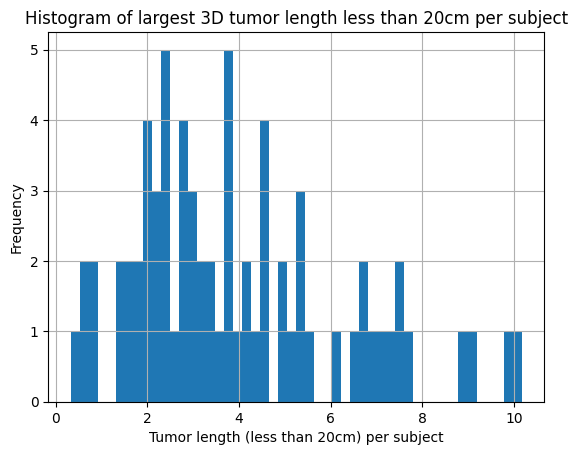

In [12]:
df3d.columns
#Plot largest_tumor_length_cm histogram, where tumor_length_cm is less than 20cm and gretar than zero, using 100 bins
df3d[ (df3d.major_axis_length_cm > 0) &  (df3d.major_axis_length_cm < 20)].major_axis_length_cm.hist(bins=50)
# Title
plt.title("Histogram of largest 3D tumor length less than 20cm per subject")
# Y label
plt.ylabel("Frequency")
# X label
plt.xlabel("Tumor length (less than 20cm) per subject")

Text(0.5, 1.0, 'Tumor area vs number of tumors')

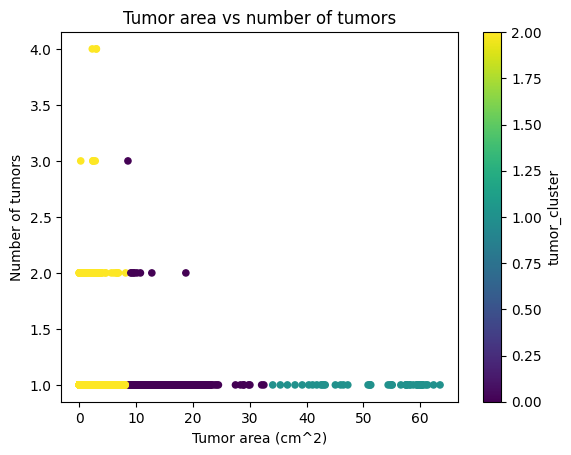

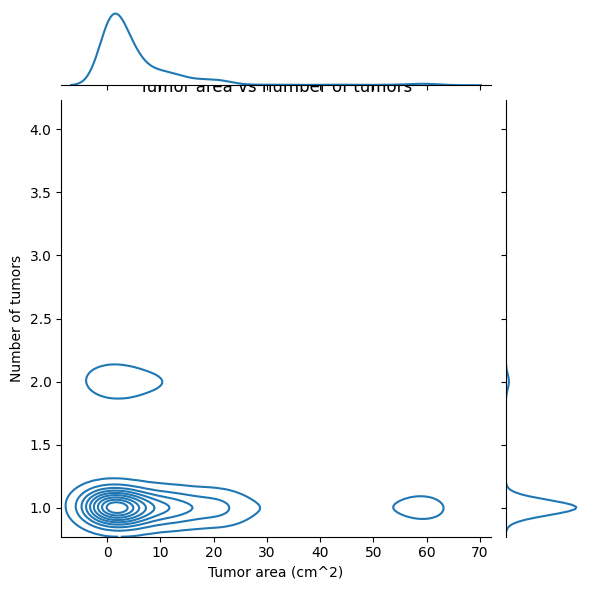

In [13]:
# cluster the tumor_area and number_of_tumors
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df2d[['tumor_area_cm2', 'number_of_tumors']])
df2d['tumor_cluster'] = kmeans.predict(df2d[['tumor_area_cm2', 'number_of_tumors']])
df2d.plot.scatter(x='tumor_area_cm2', y='number_of_tumors', c='tumor_cluster', colormap='viridis')

# Axis title
plt.xlabel('Tumor area (cm^2)')
plt.ylabel('Number of tumors')
plt.title('Tumor area vs number of tumors')

# # show density plot of tumor_area and number_of_tumors
import seaborn as sns
sns.jointplot(x='tumor_area_cm2', y='number_of_tumors', data=df2d, kind='kde')

# Axis title
plt.xlabel('Tumor area (cm^2)')
plt.ylabel('Number of tumors')
plt.title('Tumor area vs number of tumors')



In [14]:
# Create a new column for cluster of tumor_area and number_of_tumors
df2d['tumor_cluster'] = kmeans.predict(df2d[['tumor_area_cm2', 'number_of_tumors']])

In [15]:
df2d['tumor_cluster'].value_counts()

# Get mean value of tumor_area and number_of_tumors for each cluster
df2d.groupby('tumor_cluster')[['tumor_area_cm2', 'number_of_tumors']].mean()


,tumor_area_cm2,number_of_tumors
tumor_cluster,,
0,14.788059,1.031348
1,52.251725,1.000000
2,2.267455,1.062598


Index(['name', 'max_tumor_size', 'number_tumors', 'cancer_stage'], dtype='object')


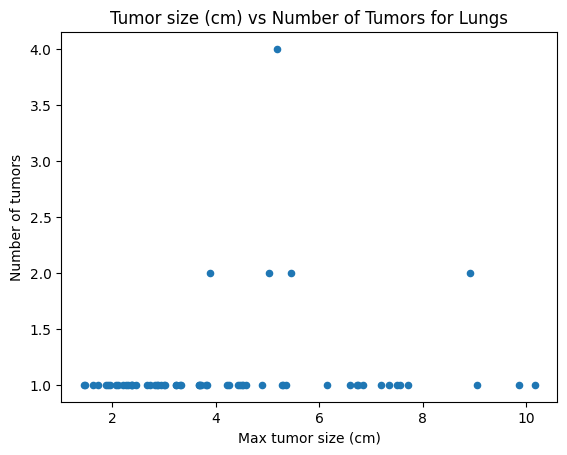

In [16]:
df_subject = pd.read_csv('/home/azureuser/cloudfiles/code/Users/data/msd_quantification/msd_lung_metrics_3D_subject.csv')
print(df_subject.columns)
# Plot scatter plot of tumor_area vs number_of_tumors where tumor_flag is 1
df_subject.plot.scatter(x='max_tumor_size', y='number_tumors')
# Axis title
plt.xlabel('Max tumor size (cm)')
plt.ylabel('Number of tumors')
plt.title('Tumor size (cm) vs Number of Tumors for Lungs')
plt.ticklabel_format(style='plain')


In [ ]:
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential
from azureml.core import Workspace, Datastore, Dataset

# Get the workspace
workspace = Workspace.from_config()

# Get subscription ID, resource group, and workspace name
workspace


# # Connect to the AzureML workspace
# subscription_id = from azure.ai.ml import MLClient
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential
from azureml.core import Workspace, Datastore, Dataset

# Get the workspace
workspace = Workspace.from_config()

# Connect to the AzureML workspace
subscription_id = workspace.subscription_id
resource_group = workspace.resource_group
workspace_name = workspace.name

ml_client = MLClient(
    DefaultAzureCredential(), subscription_id, resource_group, workspace_name
)

# Set the version number of the data asset (for example: '1')
VERSION = '6'
path = '/home/azureuser/cloudfiles/code/Users/data/msd_quantification'

# Define the Data asset object
my_data = Data(
    path=path,
    type=AssetTypes.URI_FOLDER,
    description="Liver, Lung, Colon and Pancreas quantification tumor metrics. Metrics are 2D per organ and 3D per tumor.",
    name="mds_quantification",
    version=VERSION,
)

# Create the data asset in the workspace
ml_client.data.create_or_update(my_data)
